# Text Clssification Mini Project 2

## 1. Data Loading and Exploration

### 1.1 Importing the necessary libraries:

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from scipy.sparse import csr_matrix, hstack
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from textblob import TextBlob
from nrclex import NRCLex
import seaborn as sns
import contractions
import pandas as pd
import math



# Import Spacy libary
import spacy

# Load the pre-trained spaCy model
nlp = spacy.load('en_core_web_sm')

### 1.2 Data Loading

Read positive and negative reviews

In [2]:
# Read positive and negative reviews

positive_reviews = open('Mini_Project_2_Data/positive-reviews.txt', encoding='utf-8').read().splitlines()
negative_reviews = open('Mini_Project_2_Data/negative-reviews.txt', encoding='utf-8').read().splitlines()

Read positive and negative words from files

In [3]:
# Read positive and negative words from files

positive_words = set(open('Mini_Project_2_Data/positive-words.txt').read().splitlines())
negative_words = set(open('Mini_Project_2_Data/negative-words.txt').read().splitlines())

Combine to Dataframe

In [4]:
# Combine negative and positive reviews
reviews = negative_reviews + positive_reviews

# Create a DataFrame with a 'Reviews' column
df = pd.DataFrame({'Reviews': reviews})

# Create labels
labels = [0] * len(negative_reviews) + [1] * len(positive_reviews)

# Add a 'Label' column to the DataFrame
df['Label'] = labels


In [5]:
df = df.sample(frac=1).reset_index(drop=True)
df

,Reviews,Label
0,Can't see what ink is being used.,0
1,definitely not high-end,0
2,"Clear, Beautiful Color Pictures",1
3,Motorola i90c for Nextel is cheaper with same ...,1
4,"Decent PPM, quality color, parallel or USB cap...",1
...,...,...
39995,"pretty expensive, but a reasonable price for t...",0
39996,It is fast and accurate.,1
39997,Magazine and photo-processing quality prints!,1
39998,"Screen, size and battery life.",1


<Axes: xlabel='Label'>

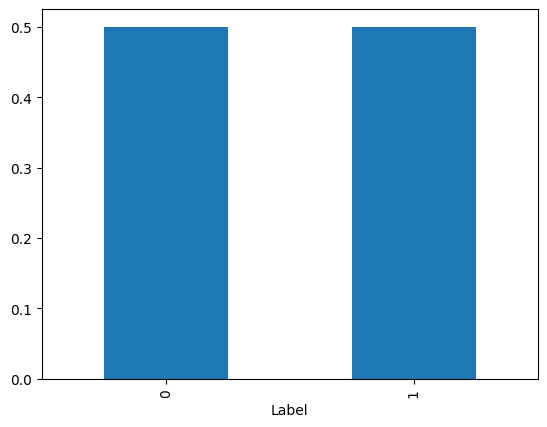

In [6]:
df['Label'].value_counts(normalize = True).plot.bar()

## 2. Text Preprocessing and Cleaning


### 2.1 Cleaning 

In [7]:
# Remove newline characters from the 'review_text' column
df['Reviews'] = df['Reviews'].str.strip()

In [8]:
# Check if there are None rows
none_rows = df[df['Reviews'] == 'None']
none_rows

,Reviews,Label
47,None,0
256,None,0
361,None,0
542,None,0
992,None,0
...,...,...
39528,None,0
39742,None,0
39750,None,1
39803,None,0


In [9]:
# Filter rows where 'review_text' is not 'None'
df = df[df['Reviews'] != 'None']

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

# Check if there are None rows
none_rows = df[df['Reviews'] == 'None']
none_rows

,Reviews,Label


+ Check Duplicate Data

In [10]:
df.duplicated().sum()

3151

In [11]:
df = df.drop_duplicates()
df.duplicated().sum()

0

+ Check if it null

In [12]:
df.isnull().sum()

Reviews    0
Label      0
dtype: int64

### 2.2 Text Preprocessing

Define a function for text preprocessing and store the results in a new column called **'cleaned_review_text'**.

1. **Remove extra spaces**:
   - Using regular expressions, eliminate any redundant spaces within the text.

2. **Convert text to lowercase**:
   - Convert all characters in the text to lowercase to ensure uniformity.

3. **Expand contractions**:
   - Utilize the `contractions.fix()` function to expand contracted words in the text.

4. **Replace repetitions of punctuation with a single punctuation**:
   - Employ regular expressions to replace consecutive occurrences of punctuation with a single instance.

5. **Remove punctuation (except '!') and numbers**:
   - Use regular expressions to eliminate all punctuation marks and numerical digits from the text, with the exception of the exclamation mark '!'.

6. **Remove emojis**:
   - Utilize either regular expressions or a library to remove emojis from the text.

7. **Tokenize text**:
   - Segment the text into individual words or tokens using a tokenizer.

8. **Remove stop words except 'no' and 'not'**:
   - Exclude common stop words, which are words that typically do not carry significant meaning, from the text. However, retain the words 'no' and 'not' as they can alter the meaning of a sentence.

9. **Lemmatization**:
   - Apply lemmatization to reduce each word to its base or dictionary form, considering the context of the word in the sentence.

10. **Join tokens back into text**:
    - Reassemble the processed tokens into coherent text after preprocessing.



In [13]:
from nltk.tokenize import word_tokenize
import string
import nltk
import re
# Define function for text preprocessing for testing
def text_preprocessing(text, is_lower_case=True):
    if pd.isna(text):  # Check for NaN values
        return ""  # Return an empty string for missing values
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Replace repetitions of punctuation with a single punctuation
    text = re.sub(r'([' + string.punctuation + r'])\1+', r'\1', text)
    
    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    
    # Remove emoticons
    emoticons = re.compile(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)')
    text = emoticons.sub('', text)
    
    # Expand contractions
    text = contractions.fix(text)
    
    # Remove stop words
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words.remove('no')
    stop_words.remove('not')

    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]

    # Join the words back into a cleaned sentence
    cleaned_text = ' '.join(words)
    
    return cleaned_text

+ Apply clean text to datafram

In [14]:
# Apply the function to the 'review_text' column and store the results in a new column 'cleaned_review_text'
df['cleaned_review_text'] = df['Reviews'].apply(text_preprocessing)

df

,Reviews,Label,cleaned_review_text
0,Can't see what ink is being used.,0,not see ink used
1,definitely not high-end,0,definitely not highend
2,"Clear, Beautiful Color Pictures",1,clear beautiful color pictures
3,Motorola i90c for Nextel is cheaper with same ...,1,motorola ic nextel cheaper body style useful f...
4,"Decent PPM, quality color, parallel or USB cap...",1,decent ppm quality color parallel usb capable ...
...,...,...,...
39696,"pretty expensive, but a reasonable price for t...",0,pretty expensive reasonable price product prod...
39697,It is fast and accurate.,1,fast accurate
39698,Magazine and photo-processing quality prints!,1,magazine photoprocessing quality prints
39699,"Screen, size and battery life.",1,screen size battery life


### 2.3 Data Virtualization 

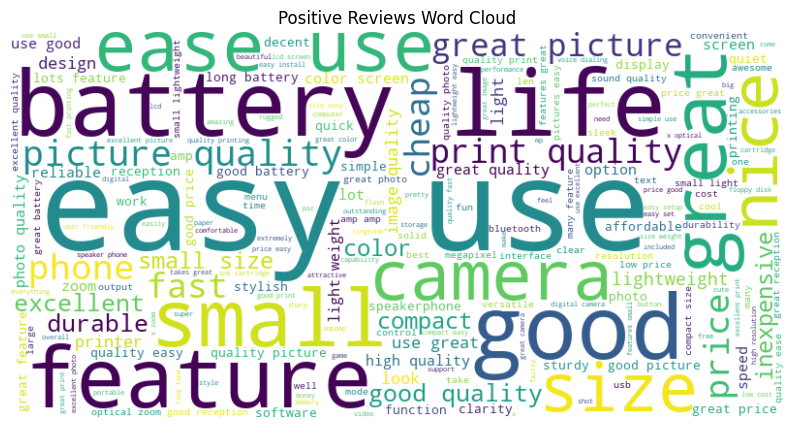

In [15]:
from wordcloud import WordCloud
#Positive Reviews Word Cloud
positive_reviews = ' '.join(df[df['Label'] == 1]['cleaned_review_text'])

plt.figure(figsize=(10, 8))
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud') 
plt.axis('off')
plt.show()

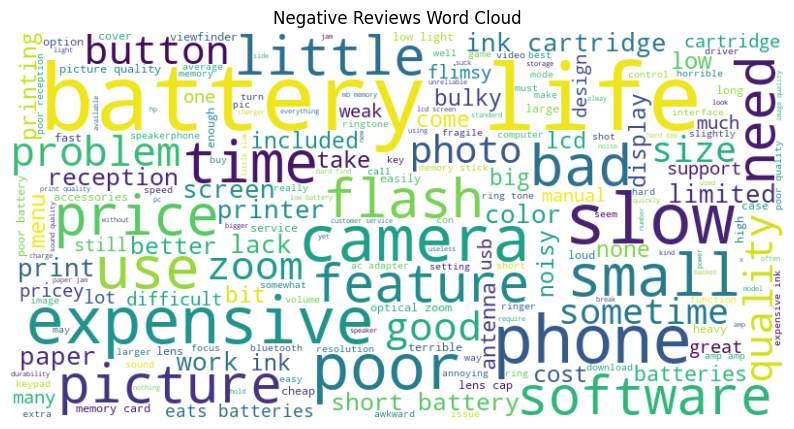

In [16]:
#Negative Reviews Word Cloud
negative_reviews = ' '.join(df[df['Label'] == 0]['cleaned_review_text'])

plt.figure(figsize=(10, 8))
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.show()

In [17]:
from collections import Counter

def get_top_words(text, n=10):
    words = text.split()
    return Counter(words).most_common(n)

top_positive_words = get_top_words(positive_reviews)
top_negative_words = get_top_words(negative_reviews)

print("\nTop 10 Positive Words:")
print(top_positive_words)

print("\nTop 10 Negative Words:")
print(top_negative_words)


Top 10 Positive Words:
[('quality', 4365), ('great', 3877), ('easy', 3756), ('use', 3493), ('good', 3337), ('small', 1951), ('features', 1947), ('price', 1733), ('size', 1478), ('battery', 1373)]

Top 10 Negative Words:
[('not', 3718), ('no', 2569), ('battery', 2113), ('life', 1338), ('slow', 1143), ('poor', 1115), ('quality', 1107), ('expensive', 946), ('ink', 912), ('small', 784)]


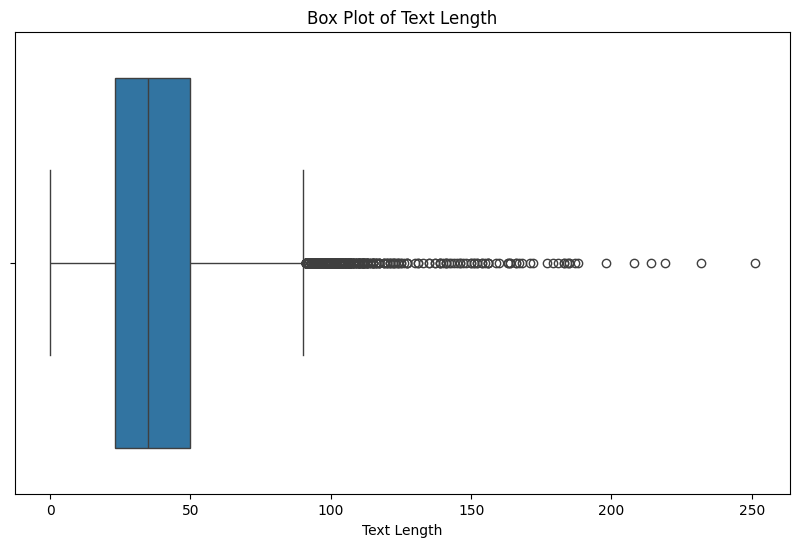

In [18]:
#Outlier Detection
import seaborn as sns

df['text_length'] = df['cleaned_review_text'].apply(len)

Q1 = df['text_length'].quantile(0.25)
Q3 = df['text_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['text_length'] < lower_bound) | (df['text_length'] > upper_bound)]

# Visualizing outliers with a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['text_length'])
plt.title('Box Plot of Text Length')
plt.xlabel('Text Length')
plt.show()

+ Data Distribution

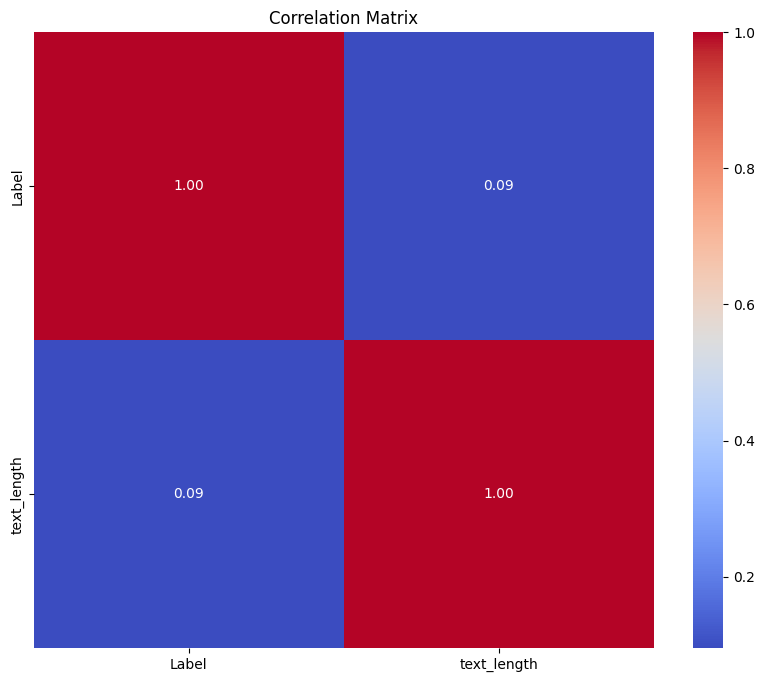

In [19]:
# Correlation Matrix (excluding non-numeric columns)
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


## 3. Feature Extraction from Text

### 3.1 Count of Positive and Negative Words in Review Text
This analysis provides a breakdown of the number of positive and negative words found in the review text. Positive and negative sentiments are quantified to gain insights into the overall tone of the reviews.


In [20]:
def count_positive_words(text):

    words = text.lower().split()
    count = sum(1 for word in words if word in positive_words)
    return count

def count_negative_words(text):

    words = text.lower().split()
    count = sum(1 for word in words if word in negative_words)
    return count

+ Apply count_negative_words and count_positive_words

In [21]:
# Apply function count_positive_words and count_negative_words to cleaned_review_text
df['count_positive_words'] = df['cleaned_review_text'].apply(count_positive_words)
df['count_negative_words'] = df['cleaned_review_text'].apply(count_negative_words)

### 3.2 Check for Presence of 'no' or 'not' in Review Text
This analysis examines whether the review text includes the words 'no' or 'not'. Identifying the presence of these words can be crucial for understanding negation in the sentiment expressed within the reviews.


In [22]:
def contain_no(cleaned_review_text):
    tokens = word_tokenize(cleaned_review_text)
    contain_no = int('no' in tokens)
    return contain_no

def contain_not(cleaned_review_text):
    tokens = word_tokenize(cleaned_review_text)
    contain_not = int('not' in tokens)
    return contain_not

+ Apply function contains_no and contains_not to cleaned_review_text

In [23]:
# Apply function contains_no and contains_not to cleaned_review_text
df['contain_no'] = df['cleaned_review_text'].apply(contain_no)
df['contain_not'] = df['cleaned_review_text'].apply(contain_not)

In [24]:
df.head(10)

,Reviews,Label,cleaned_review_text,text_length,count_positive_words,count_negative_words,contain_no,contain_not
0,Can't see what ink is being used.,0,not see ink used,16,0,0,0,1
1,definitely not high-end,0,definitely not highend,22,0,0,0,1
2,"Clear, Beautiful Color Pictures",1,clear beautiful color pictures,30,2,0,0,0
3,Motorola i90c for Nextel is cheaper with same ...,1,motorola ic nextel cheaper body style useful f...,53,2,0,0,0
4,"Decent PPM, quality color, parallel or USB cap...",1,decent ppm quality color parallel usb capable ...,58,3,0,0,0
5,See Review Above,0,see review,10,0,0,0,0
6,"Numerous features, color screen, light",1,numerous features color screen light,36,0,0,0,0
7,Print quality is OK,1,print quality ok,16,0,0,0,0
8,Cheap,1,cheap,5,0,1,0,0
9,"Small, light, great battery life, bluetooth en...",1,small light great battery life bluetooth enabl...,63,2,0,0,0


### 3.3 Check for Presence of '!' in Review Text
This analysis looks for the presence of the exclamation mark '!' within the review text. The presence of '!' can indicate emphasis or heightened emotion in the expressed sentiments.


In [25]:
def contain_exclamation(cleaned_review_text):
    tokens = word_tokenize(cleaned_review_text)
    contain_exclamation = int('!' in tokens)
    return contain_exclamation

+ Apply function contain_exclamation to cleaned_review_text

In [26]:
# Apply function contain_exclamation to cleaned_review_text
df['contain_exclamation'] = df['cleaned_review_text'].apply(contain_exclamation)

In [27]:
df.head(10)

,Reviews,Label,cleaned_review_text,text_length,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation
0,Can't see what ink is being used.,0,not see ink used,16,0,0,0,1,0
1,definitely not high-end,0,definitely not highend,22,0,0,0,1,0
2,"Clear, Beautiful Color Pictures",1,clear beautiful color pictures,30,2,0,0,0,0
3,Motorola i90c for Nextel is cheaper with same ...,1,motorola ic nextel cheaper body style useful f...,53,2,0,0,0,0
4,"Decent PPM, quality color, parallel or USB cap...",1,decent ppm quality color parallel usb capable ...,58,3,0,0,0,0
5,See Review Above,0,see review,10,0,0,0,0,0
6,"Numerous features, color screen, light",1,numerous features color screen light,36,0,0,0,0,0
7,Print quality is OK,1,print quality ok,16,0,0,0,0,0
8,Cheap,1,cheap,5,0,1,0,0,0
9,"Small, light, great battery life, bluetooth en...",1,small light great battery life bluetooth enabl...,63,2,0,0,0,0


### 3.4 Log of Review Text Length
This analysis calculates the logarithm of the length of the review text. Taking the logarithm of the length can help normalize the data and highlight differences in text length more effectively.


In [28]:
def log_review_length(review_text):
    review_length = len(review_text)
    if review_length == 0:
        return 0  # Return 0 if the review length is 0
    log_length = math.log(review_length)
    return log_length

+ Apply function log_review_length to cleaned_review_text

In [31]:
# Apply function log_review_length to cleaned_review_text
df['log_review_length'] = df['cleaned_review_text'].apply(log_review_length)

### 3.5 Count of Words with POS Tags (Pronouns, Adjectives)
This analysis counts the number of words in the review text that are tagged as Pronouns and Adjectives. Pronouns and adjectives play a significant role in conveying sentiment and describing characteristics, making their frequency useful for sentiment analysis.


In [32]:
def count_pos_words(review_text, pos_tag):
    doc = nlp(review_text)
    count = sum(1 for token in doc if token.pos_ == pos_tag)
    return count

+ Apply function count_pos_words to cleaned_review_text

In [33]:
# df['pronoun_count'] = df['cleaned_review_text'].apply(lambda x: count_pos_words(x, 'PRON'))
# df['adjective_count'] = df['cleaned_review_text'].apply(lambda x: count_pos_words(x, 'ADJ'))
# df['adverb_count'] = df['cleaned_review_text'].apply(lambda x: count_pos_words(x, 'ADV'))

### 3.6 Emotion Label Based on Review Text
This analysis assigns an emotion label to each review text based on the predominant emotion expressed. Emotions such as joy, sadness, anger, surprise, and others may be identified using sentiment analysis techniques, helping to categorize the overall emotional tone of the reviews.


In [34]:
def get_emotion_label(phrase):
    # Tokenize the phrase
    tokens = word_tokenize(phrase)

    # Define emotion word list
    emotion_words = []

    for i in range(len(tokens)):
      # Call NRCLex constructor
      emotion = NRCLex(tokens[i])
      # Get affect_dict
      affect_dict = emotion.affect_dict
      # Extract emotion words from affect_dict values
      for sublist in affect_dict.values():
        emotion_words.extend(sublist)

    # Define positive and negative emotion groups
    positive_emotions = ['anticipation', 'trust', 'positive', 'joy', 'surprise']
    negative_emotions = ['fear', 'anger', 'negative', 'sadness', 'disgust']

    # Count occurrences of positive and negative words
    positive_count = sum(emotion_words.count(emotion) for emotion in positive_emotions)
    negative_count = sum(emotion_words.count(emotion) for emotion in negative_emotions)

    # Determine sentiment label based on counts
    if positive_count > negative_count:
        return 1
    elif positive_count < negative_count:
        return 0
    else:
        return 2

# # Sample usage
# phrase = "This movie is great and wonderful, but it made me sad."
# emotion_label = get_emotion_label(phrase)
# print("Emotion label:", emotion_label)

+ Apply function get_emotion_label to cleaned_review_text

In [35]:
# Apply function get_emotion_label to cleaned_review_text
df['emotion_label'] = df['cleaned_review_text'].apply(get_emotion_label)

### 3.7 Sentiment Score Calculation
This analysis computes the sentiment score for each review text. The sentiment score quantifies the overall sentiment expressed in the review, typically ranging from negative to positive values.


In [36]:
def calculate_sentiment_score(phrase):
    # Create a TextBlob object
    blob = TextBlob(phrase)

    # Get the sentiment score
    sentiment_score = blob.sentiment.polarity

    return sentiment_score

# Sample usage
# phrase = "This movie is great and wonderful, but it made me sad."
# sentiment_score = calculate_sentiment_score(phrase)
# print("Sentiment score:", sentiment_score)

+ Apply function calculate_sentiment_score to cleaned_review_text

In [37]:
# Apply function calculate_sentiment_score to cleaned_review_text
df['sentiment_score'] = df['cleaned_review_text'].apply(calculate_sentiment_score)

In [38]:
df.head(5)

,Reviews,Label,cleaned_review_text,text_length,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation,log_review_length,emotion_label,sentiment_score
0,Can't see what ink is being used.,0,not see ink used,16,0,0,0,1,0,2.772589,2,0.000000
1,definitely not high-end,0,definitely not highend,22,0,0,0,1,0,3.091042,2,0.000000
2,"Clear, Beautiful Color Pictures",1,clear beautiful color pictures,30,2,0,0,0,0,3.401197,1,0.475000
3,Motorola i90c for Nextel is cheaper with same ...,1,motorola ic nextel cheaper body style useful f...,53,2,0,0,0,0,3.970292,2,0.300000
4,"Decent PPM, quality color, parallel or USB cap...",1,decent ppm quality color parallel usb capable ...,58,3,0,0,0,0,4.060443,1,0.241667


## 4. Classification Model Building


### 4.1 Train-Test Split for Model Evaluation

In [39]:
df = df.drop('Reviews',axis=1)

In [40]:
df = df.drop('text_length',axis=1)

In [41]:
y = df['Label']
X = df.drop(columns=['Label'],axis=1)

In [42]:
from gensim.models import KeyedVectors
import os

data_path = "D:/Term 10/NLP/group6_mini_project_02_code/"
path_to_model = os.path.join(data_path, 'GoogleNews-vectors-negative300.bin')

word2vec_model = KeyedVectors.load_word2vec_format(path_to_model, binary=True)


In [50]:
import numpy as np
def text_to_word_embeddings(text_data, word2vec_model):
    # Initialize an empty list to store the word embeddings for each review
    embeddings = []
    
    for review in text_data:
        # Tokenize the review into individual words
        words = review.split()
        # Filter out words not in the Word2Vec vocabulary
        words = [word for word in words if word in word2vec_model]
        # Get the embeddings for each word and take the mean to get the review's embedding
        if words:
            embeddings.append(np.mean(word2vec_model[words], axis=0))
        else:
            # If no words in the vocabulary, return a vector of zeros
            embeddings.append(np.zeros(word2vec_model.vector_size))
            
    return np.array(embeddings)

In [51]:

# Convert text data using Word2Vec embeddings
X_text_transformed = text_to_word_embeddings(df['cleaned_review_text'], word2vec_model)

# Convert numeric features to arrays
X_numeric_features = X.drop(columns=['cleaned_review_text']).values

# Convert numeric features to sparse matrices
X_numeric_sparse = csr_matrix(X_numeric_features)

# Concatenate the word embeddings and other features
X = hstack([X_text_transformed, X_numeric_sparse])


In [53]:
X

<36550x308 sparse matrix of type '<class 'numpy.float64'>'
	with 11046655 stored elements in COOrdinate format>

In [54]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split( X , df['Label'], test_size=0.2, random_state=42, stratify= df['Label'])

In [55]:
scaler = MaxAbsScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Convert the sparse matrix to a dense array for visualization
X_train_dense = X_train.toarray()
X_train_scaled_dense = X_train_scaled.toarray()

# Create a DataFrame for better visualization (optional)
columns = [f'Feature_{i}' for i in range(X_train_dense.shape[1])]
X_train_df = pd.DataFrame(data=X_train_dense, columns=columns)
X_train_scaled_df = pd.DataFrame(data=X_train_scaled_dense, columns=columns)


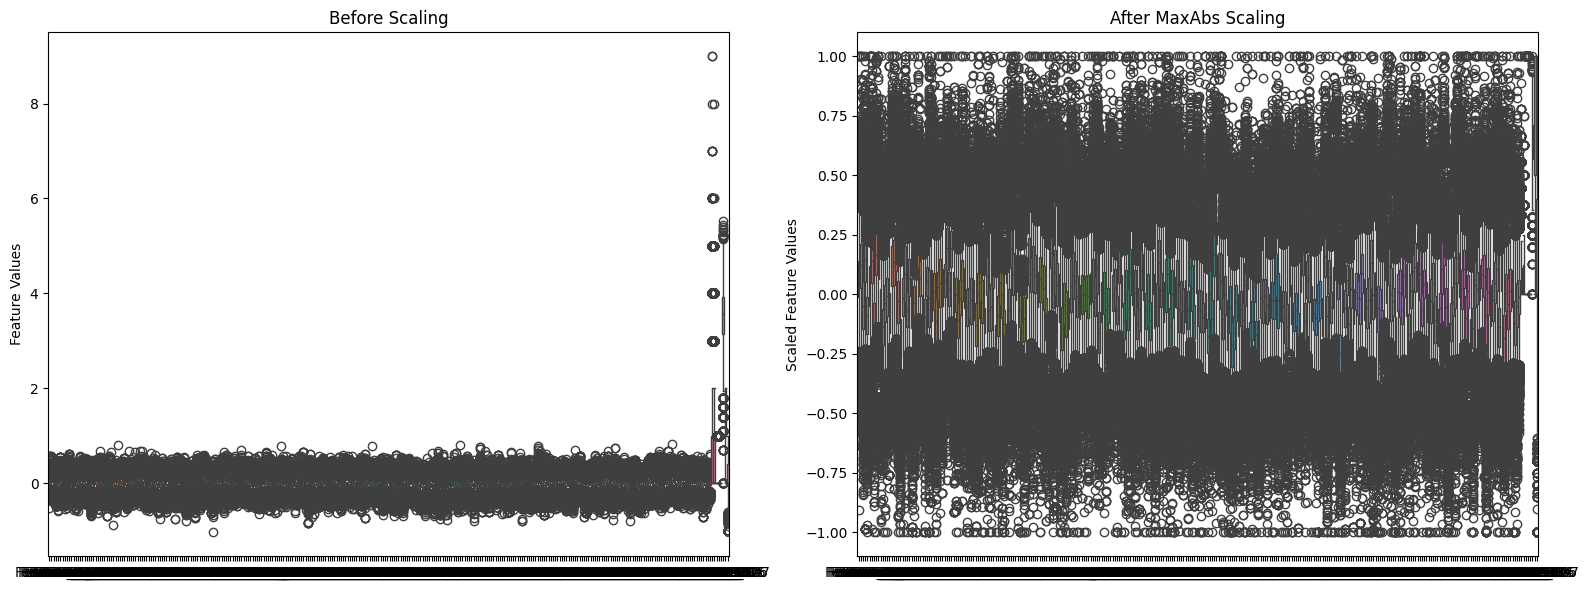

In [56]:

# Plot side-by-side boxplots
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=X_train_df, orient='v')
plt.title('Before Scaling')
plt.ylabel('Feature Values')

plt.subplot(1, 2, 2)
sns.boxplot(data=X_train_scaled_df, orient='v')
plt.title('After MaxAbs Scaling')
plt.ylabel('Scaled Feature Values')

plt.tight_layout()
plt.show()


### 4.8 Model Training: Multi-layer Perceptron classifier (MLPClassifier)

In [57]:
from sklearn.neural_network import MLPClassifier

# Correct variable name for MLPClassifier
mlp = MLPClassifier(activation='tanh', hidden_layer_sizes=(100,), max_iter=200, solver = 'adam')


In [58]:
mlp.fit(X_train_scaled_df,y_train)

c:\Users\kimh1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh')

In [87]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(max_iter=10000, solver='lbfgs',C=10)
# And fit the data to the model
logistic.fit(X_train_scaled_df,y_train)

LogisticRegression(C=10, max_iter=10000)

## 5. Model Evaluation and Accuracy Metrics 

In [60]:
X_test_numeric_scaled = scaler.transform(X_test)

In [61]:
MLPClassifier_predictions = mlp.predict(X_test_numeric_scaled)
logistic_predictions = logistic.predict(X_test_numeric_scaled)

c:\Users\kimh1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\kimh1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [62]:

print("MLPClassifier Predictions :", MLPClassifier_predictions)
print("lr Predictions :", logistic_predictions)

MLPClassifier Predictions : [0 1 0 ... 1 1 0]
lr Predictions : [0 1 0 ... 1 1 0]


+ Model Accuracy

In [63]:
# Calculate accuracy for each classifier
accuracy_MLPClassifier = accuracy_score(y_test, MLPClassifier_predictions)

# Print accuracy for each classifier

print("Accuracy - MLPClassifier:", accuracy_MLPClassifier)



Accuracy - MLPClassifier: 0.9232558139534883


+ Model Classification Report

In [64]:
from sklearn.metrics import classification_report

# Function to print classification report
def print_classification_report(model_name, y_true, y_pred):
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred))
    print("="*50)
    
# Print classification reports

print_classification_report("MLPClassifier", y_test, MLPClassifier_predictions)


Classification Report for MLPClassifier:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3566
           1       0.92      0.93      0.93      3744

    accuracy                           0.92      7310
   macro avg       0.92      0.92      0.92      7310
weighted avg       0.92      0.92      0.92      7310



## 6. Predictions on Example Reviews 

In [66]:
# Example Reviews
new_reviews = [
    "This movie was fantastic! I loved every moment of it.",
    "The product quality was terrible. I regret buying it.",
    "The customer service was amazing. They resolved my issue promptly.",
    "I have never experienced such poor service. Avoid this company.",
    "The book was captivating and well-written. Highly recommend it.",
]

# Text Preprocessing for New Reviews
cleaned_new_reviews = [text_preprocessing(review) for review in new_reviews]

# Convert new reviews to Word2Vec embeddings
new_reviews_transformed = text_to_word_embeddings(cleaned_new_reviews, word2vec_model)

# Convert numeric features for new reviews
new_reviews_numeric_features = pd.DataFrame({
    'count_positive_words': [count_positive_words(review) for review in cleaned_new_reviews],
    'count_negative_words': [count_negative_words(review) for review in cleaned_new_reviews],
    'contain_no': [contain_no(review) for review in cleaned_new_reviews],
    'contain_not': [contain_not(review) for review in cleaned_new_reviews],
    'contain_exclamation': [contain_exclamation(review) for review in cleaned_new_reviews],
    'log_review_length': [log_review_length(review) for review in cleaned_new_reviews],
    'emotion_label': [get_emotion_label(review) for review in cleaned_new_reviews],
    'sentiment_score': [calculate_sentiment_score(review) for review in cleaned_new_reviews],
})

# Concatenate the word embeddings and other features for new reviews
new_reviews_data = hstack([new_reviews_transformed, csr_matrix(new_reviews_numeric_features)])


In [67]:

# Scale the new reviews data using MaxAbsScaler
new_reviews_scaled = scaler.transform(new_reviews_data)
# Make Predictions for each model
mlp_predictions = mlp.predict(new_reviews_scaled)


c:\Users\kimh1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [71]:
# Display Predictions
print("MLPClassifier Predictions:", mlp_predictions)
print("MLPClassifier Predictions:", logistic.predict(new_reviews_scaled))

MLPClassifier Predictions: [1 0 0 0 1]
MLPClassifier Predictions: [1 0 1 0 1]


c:\Users\kimh1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [69]:
import joblib
joblib.dump(mlp, 'mlp.pkl')

['mlp.pkl']

In [88]:
joblib.dump(logistic, 'lr.pkl')

['lr.pkl']

In [73]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [78]:
from sklearn.svm import SVC
# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=10)  # You can choose different kernels, such as 'rbf', 'poly', etc.
# Train the classifier on the training data
svm_classifier.fit(X_train_scaled_df,y_train)

SVC(C=10, kernel='linear')

In [86]:
joblib.dump(svm_classifier, 'svm_classifier.pkl')

['svm_classifier.pkl']